# Introduction
This notebook provides a quick learning resource for manipulating image data with OpenCV, following the Basics and Advanced sections of this youtube video: https://www.youtube.com/watch?v=oXlwWbU8l2o

Original code for the course can be found at Jason Dsouza's [github profile](https://github.com/jasmcaus/opencv-course).

Images of the Sun are used as examples, which can be downloaded for a given year, e.g. 2021, using a link similar to the following: https://spaceweather.com/images2021/. Of course, any image will do, just place the image file(s) in a folder on your file system, and provide the appropriate data_dir and image_files string values below. It is helpful to have several different images to test with.

## References
- https://pypi.org/project/opencv-python/
- https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/
- https://forums.developer.nvidia.com/t/python-what-is-the-four-characters-fourcc-code-for-mp4-encoding-on-tx2/57701/6
- https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
- https://docs.opencv.org/4.5.1/d9/d8b/tutorial_py_contours_hierarchy.html
- 

In [1]:
# Import packages
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
from opencv_tools import load_frame_gray, resize_frame, translate_frame, rotate_frame, flip_frame, print_frame_info, show_frame
from opencv_tools import plot_frame_histogram
%matplotlib inline

In [2]:
# Set parameters
# data_dir: a string containing the directory where image files are located
# image_files: a list containing strings, with each string specifying the name of an image file, including extension
# image_index: an integer that specifies which image_file value to analyze in the code blocks below
# Note that os.listdir or glob could also be used to obtain a list of all files in data_dir
data_dir = "/home/fdpearce/Documents/Projects/data/Images/Sun/"
image_files = ["27aug21_hmi4096_blank.jpg", "28aug21_hmi4096_blank.jpg", "29aug21_hmi4096_blank.jpg", "30aug21_hmi4096_blank.jpg", \
               "31aug21_hmi4096_blank.jpg", "01sep21_hmi4096_blank.jpg", "02sep21_hmi4096_blank.jpg", "03sep21_hmi4096_blank.jpg", \
               "04sep21_hmi4096_blank.jpg", "05sep21_hmi4096_blank.jpg"]
image_index = 0

## Basics 

### 1. Read and Resize an Image/Video Frame

In [3]:
# Read in an example image to use for testing
img_path = os.path.join(data_dir, image_files[image_index])
img = load_frame_gray(img_path)
img_orig = img.copy()

In [4]:
resize_scale = .25
img_resize = resize_frame(img, scale=resize_scale)

In [5]:
show_frame(img_resize, "Resized Sun Image")

In [6]:
print_frame_info(img, "Original")
print_frame_info(img_resize, "Resized")

Original Image Shape: Height=4096, Width=4096, Channels=3
Resized Image Shape: Height=1024, Width=1024, Channels=3


### 2. Draw Circle on Image/Video Frame

In [7]:
# Distance dimensions are in pixels (i.e. int)
circle_size = (img_resize.shape[1]//2, img_resize.shape[0]//2)
circle_radius = 472
circle_color = (0, 0, 255)
circle_thickness = 2
img_circle = cv.circle(img_resize.copy(), circle_size, circle_radius, circle_color, thickness=circle_thickness)

In [8]:
show_frame(img_circle, "Resized Sun Image w/ Circle")

### 3. Draw Text on Image/Video Frame

In [9]:
text_str = "Circle Center"
text_loc = (img_resize.shape[1]//2, img_resize.shape[0]//2)
text_font = cv.FONT_HERSHEY_TRIPLEX
text_scale = 1
text_color = (255, 0, 0)
text_thickness = 2
img_text = cv.putText(img_circle.copy(), text_str, text_loc, text_font, text_scale, text_color, text_thickness)

In [10]:
show_frame(img_text, "Resized Sun Image w/ Circle + Text")

### 4. Convert to Grayscale

In [11]:
# Use the raw, resized sun image for subsequent analysis, e.g. edge detection, contours, etc
gray = cv.cvtColor(img_resize.copy(), cv.COLOR_BGR2GRAY)

In [12]:
show_frame(gray, "Resized Sun Image w/ Circle + Text in Grayscale")

### 5. Blur an Image

In [13]:
blur_kernal_size = (3, 3)
blur_border = cv.BORDER_DEFAULT
blur = cv.GaussianBlur(gray.copy(), blur_kernal_size, blur_border)

In [14]:
show_frame(blur, "Blurred, Resized Sun Image w/ Circle + Text in Grayscale")

### 6. Find Edges in an Image

In [15]:
threshold1 = 125
threshold2 = 175
canny = cv.Canny(blur, threshold1, threshold2)

In [16]:
show_frame(canny, "Blurred, Resized Sun Image Edges w/ Circle + Text in Grayscale")

### 7. Dilate an Image

In [17]:
dilated_kernal_size = (3, 3)
dilated_iterations = 1
dilated = cv.dilate(canny, dilated_kernal_size, dilated_iterations)

In [18]:
show_frame(dilated, "Dilated, Resized Sun Image Edges w/ Circle + Text in Grayscale")

### 8. Eroding an Image

In [19]:
eroded_kernal_size = (3, 3)
eroded_iterations = 1
eroded = cv.erode(dilated, eroded_kernal_size, eroded_iterations)

In [20]:
show_frame(eroded, "Eroded, Resized Sun Image Edges w/ Circle + Text in Grayscale")

### 9. Resize an Image

In [21]:
resized_size = (500, 500)
resized_interp = cv.INTER_AREA
resized = cv.resize(img_orig, resized_size, interpolation=resized_interp)

In [22]:
show_frame(resized, "Resized Sun Image")

### 10. Cropping an Image

In [23]:
cropped_row_indices = (50, 200)
cropped_col_indices = (200, 400)
cropped = resized[cropped_row_indices[0]:cropped_row_indices[1], cropped_col_indices[0]:cropped_col_indices[1]]

In [24]:
show_frame(cropped, "Cropped Sun Image")

### 11. Translating an Image

In [25]:
translated_x = 100
translated_y = 50
translated = translate_frame(resized.copy(), translated_x, translated_y)

In [26]:
show_frame(translated, "Translated Sun Image")

### 12. Rotating an Image

In [27]:
rotated_angle = 45
rotated = rotate_frame(translated.copy(), rotated_angle)

In [28]:
show_frame(rotated, "Rotated, Translated Sun Image")

### 13. Flip an Image

In [29]:
flipped_code = 0
flipped = flip_frame(resized.copy(), flipped_code)

In [30]:
show_frame(flipped, "Flipped Sun Image")

### 14. Find Contours using Canny Edges

In [31]:
contour_output = cv.RETR_LIST
contour_method = cv.CHAIN_APPROX_NONE
contours_canny, hierarchies_canny = cv.findContours(canny, contour_output, contour_method)

In [32]:
print(f"{len(contours_canny)} Contour(s) found")
contours_canny[0:2]

25 Contour(s) found


[array([[[  66, 1001]],
 
        [[  67, 1002]],
 
        [[  67, 1001]]], dtype=int32),
 array([[[ 162,  996]],
 
        [[ 162,  997]],
 
        [[ 162,  998]],
 
        [[ 162,  999]],
 
        [[ 162, 1000]],
 
        [[ 162,  999]],
 
        [[ 162,  998]],
 
        [[ 162,  997]]], dtype=int32)]

In [33]:
hierarchies_canny[0, :5, :]

array([[ 1, -1, -1, -1],
       [ 2,  0, -1, -1],
       [ 3,  1, -1, -1],
       [ 4,  2, -1, -1],
       [ 5,  3, -1, -1]], dtype=int32)

### 15. Thresholding an Image

In [34]:
thresh_cutoff = 125
thresh_color = 255
thresh_type = cv.THRESH_BINARY
ret, thresh = cv.threshold(gray, thresh_cutoff, thresh_color, thresh_type)

In [35]:
show_frame(thresh, "Thresholded Sun Image")

### 16. Find Contours using Thresholded Image

In [36]:
contour_output = cv.RETR_LIST
contour_method = cv.CHAIN_APPROX_NONE
contours_thresh, hierarchies_thresh = cv.findContours(thresh, contour_output, contour_method)

In [37]:
print(f"{len(contours_thresh)} Contour(s) found")
contours_thresh[0]

17 Contour(s) found


array([[[380, 803]],

       [[381, 802]],

       [[382, 802]],

       [[383, 803]],

       [[384, 804]],

       [[384, 805]],

       [[383, 806]],

       [[382, 805]],

       [[381, 805]],

       [[380, 804]]], dtype=int32)

In [38]:
hierarchies_thresh[0, :5, :]

array([[ 1, -1, -1, -1],
       [ 2,  0, -1, -1],
       [ 3,  1, -1, -1],
       [ 4,  2, -1, -1],
       [ 5,  3, -1, -1]], dtype=int32)

### 17. Display Contours

In [39]:
drawcont_color = (0, 255, 0)
drawcont_thickness = 2
img_cont = cv.drawContours(img_resize.copy(), contours_canny, -1, drawcont_color, drawcont_thickness)

In [40]:
show_frame(img_cont, "Contours of Sun Image")

In [41]:
img_cont.shape

(1024, 1024, 3)

## Advanced

### 18. Changing the ColorSpace of an Image

In [42]:
hsv = cv.cvtColor(img_resize.copy(), cv.COLOR_BGR2HSV)

In [43]:
show_frame(hsv, "Sun Image in HSV")

In [44]:
lab = cv.cvtColor(img_resize.copy(), cv.COLOR_BGR2LAB)

In [45]:
show_frame(lab, "Sun Image in LAB")

### 19. Split an Image into its Color Channels

In [46]:
b, g, r = cv.split(img_resize.copy())

In [47]:
show_frame(b, "Blue Channel of Sun Image")

In [48]:
show_frame(g, "Green Channel of Sun Image")

In [49]:
show_frame(r, "Red Channel of Sun Image")

In [50]:
# Merge channels back together
bgr = cv.merge([b, g, r])

In [51]:
show_frame(bgr, "Merged Sun Image")

### 20. Blurring an Image (cont)

In [52]:
avg_kernal = (3, 3)
avg = cv.blur(img_resize.copy(), avg_kernal)

In [53]:
show_frame(avg, "Blurred (Avg) Sun Image")

In [54]:
med_kernal_size = 3
med = cv.medianBlur(img_resize.copy(), med_kernal_size)

In [55]:
show_frame(med, "Blurred (Median) Sun Image")

In [56]:
bilat_diam = 5
bilat_color = 15
bilat_space = 15
bilateral = cv.bilateralFilter(img_resize.copy(), bilat_diam, bilat_color, bilat_space)

In [57]:
show_frame(bilateral, "Blurred (Bilateral) Sun Image")

### 21. Bitwise Operations

In [58]:
blank = np.zeros((400, 400), dtype='uint8')
rectange = cv.rectangle(blank.copy(), (30, 30), (370, 370), 255, -1)
circle = cv.circle(blank.copy(), (200, 200), 200, 255, -1)

In [59]:
bitwise_and = cv.bitwise_and(rectange, circle)

In [60]:
show_frame(bitwise_and, "Bitwise AND")

In [61]:
bitwise_or = cv.bitwise_or(rectange, circle)

In [62]:
show_frame(bitwise_or, "Bitwise OR")

In [63]:
bitwise_xor = cv.bitwise_xor(rectange, circle)

In [64]:
show_frame(bitwise_xor, "Bitwise XOR")

In [65]:
bitwise_not = cv.bitwise_not(rectange)

In [66]:
show_frame(bitwise_not, "Bitwise NOT")

### 22. Masking an Image

In [67]:
mask_circle_radius = 50
masked_circle_center_x = 130
masked_circle_center_y = -50
mask_blank = np.zeros(gray.shape[0:2], dtype='uint8')
mask_circle = cv.circle(mask_blank.copy(), (mask_blank.shape[1]//2+masked_circle_center_x, mask_blank.shape[0]//2+masked_circle_center_y), mask_circle_radius, 255, thickness=-1)

In [68]:
mask_gray = cv.bitwise_and(gray, gray, mask=mask_circle)
show_frame(mask_gray, "Masked Sun Image")

In [69]:
mask_bgr = cv.bitwise_and(img_resize, img_resize, mask=mask_circle)
show_frame(mask_bgr, "Masked Sun Image")

### 23. Computing Histograms of Image Pixel Values

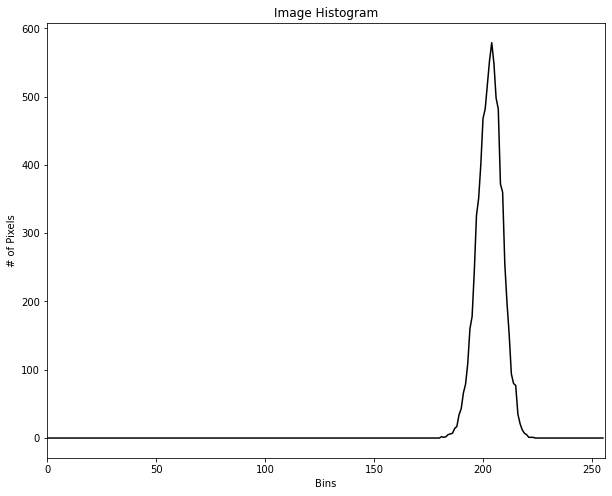

In [70]:
# Histogram for Grayscale Image
plot_frame_histogram({'images': [gray], 'mask': mask_circle})

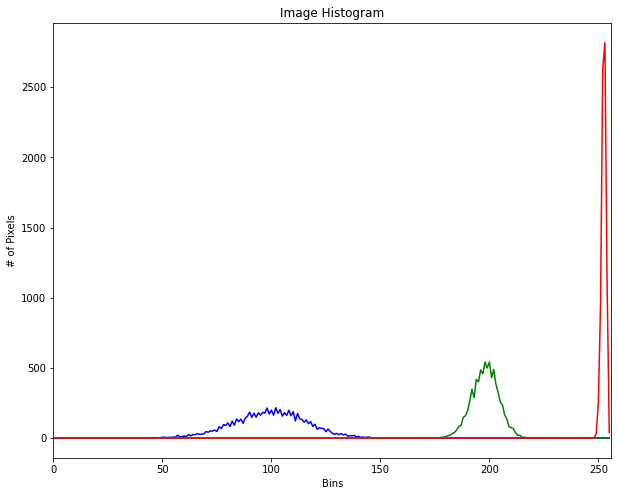

In [71]:
plot_frame_histogram({'images': [img_resize], 'channels': [0, 1, 2], 'mask': mask_circle}, {'channel_colors': ['b', 'g', 'r']})

### 24. Adaptive Thresholding of an Image

In [72]:
athresh_maxval = 255
athresh_adamethod = cv.ADAPTIVE_THRESH_MEAN_C
#athresh_adamethod = cv.ADAPTIVE_THRESH_GAUSSIAN_C
athresh_thrmethod = cv.THRESH_BINARY
athresh_blocksize = 11
athresh_c = 0
adaptive_thresh = cv.adaptiveThreshold(gray, athresh_maxval, athresh_adamethod, athresh_thrmethod, athresh_blocksize, athresh_c)

In [73]:
show_frame(adaptive_thresh, "Adaptive Thresholded Sun Image")

### 25. Edge Detection in an Image (cont)

In [74]:
# Laplacian
lap_ddepth = cv.CV_64F
lap = cv.Laplacian(gray, lap_ddepth)
lap = np.uint8(np.absolute(lap))

In [75]:
show_frame(lap, "Laplacian of Sun Image")

In [76]:
# Sobel
sob_ddep = cv.CV_64F
sobelx = cv.Sobel(gray, sob_ddep, 1, 0)
sobely = cv.Sobel(gray, sob_ddep, 0, 1)

In [77]:
show_frame(sobelx, "Sobel X of Sun Image")

In [78]:
show_frame(sobely, "Sobel Y of Sun Image")

In [79]:
combined_sobel = cv.bitwise_or(sobelx, sobely)
show_frame(combined_sobel, "Combined Sobel of Sun Image")